<a href="https://colab.research.google.com/github/alexandragrecu/Bark-and-Purr/blob/master/Copie_a_blocnotesului_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌡️**Temperature prediction using Time Series**

---



According to [NOAA's 2020 Annual Climate Report](https://www.climate.gov/news-features/understanding-climate/climate-change-global-temperature) the combined land and ocean temperature has increased at an average rate of 0.08 degrees Celsius per decade since 1880. While natural variability plays some part, the preponderance of evidence indicates that human activities—particularly emissions of heat-trapping greenhouse gases—are mostly responsible for making our planet warmer.

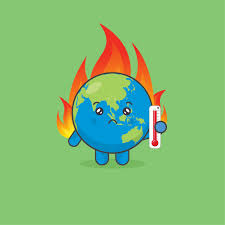

## 📌 Our task


You are given two datasets representing average temperatures in Romania (since 1902 to 2020). The first dataset represents *the anual average temperatures* and the other represents *the monthly average temperatures*.

For each time series you have to:

- Build a model forthe time series and explain all the steps that you go through;

- Use that model to forecast the next 20 values in the time seriesand plot themtogether with the initial time series.

---



## 💾 The datasets
Let's take a look at the data, which consists of two files:

- <code>annual_temperatures.csv</code>: contains all average temperatures recorded annualy in Romania (as well as in the romanian counties) from 1902 to 2020.
- <code>monthly_temperatures.csv</code>: contains all average temperatures recorded monthly in Romania from 1902 to 2020.

This datasets were taken from [*Climate Change Knowledge Portal*](https://climateknowledgeportal.worldbank.org/) site and can be downloaded from [here](https://climateknowledgeportal.worldbank.org/download-data).

For downloading the datasets, you have to set:
- COLLECTION as CRU(Observed)
- VARIABLE as Mean-Temperature
- AGGREGATION as Annual/Monthly
- COUNTRY as Romania
- TIME PERIOD as Historical Reference Period, 1901-2020

If you don't want to download them, I've already downloaded them and you can visualize them [here](https://drive.google.com/drive/folders/1bomwJSMm4LJ6zxsK16UTeg6TJ95CU-9u?usp=sharing).

---



## 📈 Time series analysis

- First, we will analyse the annual temperatures, and then we will analyse the monthly temperatures.

## 📚 1. Load packages

In [2]:
import pandas as pd
import datetime as dt
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
from google.colab import files
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA, ARIMA
from time import time
#register_motplotlib_converters()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 📖 2. Reading the datasets

In [3]:
uploaded = files.upload()

Saving annual_temperatures.csv to annual_temperatures.csv


In [6]:
annual_temperatures = pd.read_csv('annual_temperatures.csv', skiprows=1)



---



## 🗠 Time series analysis - annual temperatures

In [7]:
annual_temperatures.head()

,Unnamed: 0,Romania,Alba,Arad,Arges,Bacau,Bihor,Bistrita-nasaud,Botosani,Braila,...,Salaj,Satu Mare,Sibiu,Suceava,Teleorman,Timis,Tulcea,Vaslui,Vilcea,Vrancea
0,1901,8.85,7.05,9.62,8.34,8.07,8.94,6.37,9.46,11.16,...,8.28,9.06,7.54,6.13,11.37,10.39,11.19,9.69,7.90,8.56
1,1902,7.99,6.26,8.99,7.47,6.99,8.11,5.44,8.24,10.18,...,7.37,8.12,6.69,5.02,10.56,9.96,10.07,8.54,7.19,7.49
2,1903,9.25,7.51,10.15,8.74,8.33,9.37,6.76,9.76,11.45,...,8.73,9.49,7.95,6.42,11.79,11.04,11.31,9.96,8.39,8.79
3,1904,8.65,6.99,9.84,8.10,7.58,8.95,6.19,8.85,10.70,...,8.18,8.94,7.37,5.65,11.17,10.85,10.42,9.10,7.85,8.09
4,1905,8.84,7.07,9.71,8.34,7.92,8.93,6.35,9.29,11.07,...,8.28,9.04,7.56,5.99,11.40,10.61,11.01,9.52,7.99,8.40


In [8]:
# rename first column
annual_temperatures.rename(columns={'Unnamed: 0': 'Date', 'Romania': 'Temperature'}, inplace=True)

In [9]:
# test to see if the renaming had effect
assert annual_temperatures.columns[0] == 'Date'
assert annual_temperatures.columns[1] == 'Temperature'

In [10]:
# subset the dataset
annual_temperatures = annual_temperatures[['Date', 'Temperature']]

In [11]:
annual_temperatures_copy = annual_temperatures.copy()

In [12]:
annual_temperatures.head()

,Date,Temperature
0,1901,8.85
1,1902,7.99
2,1903,9.25
3,1904,8.65
4,1905,8.84


In [13]:
# check if there are any missing values
annual_temperatures.isna().sum()

Date           0
Temperature    0
dtype: int64

Great, there are no missing values.

In [14]:
# set date as index
annual_temperatures.set_index('Date', inplace=True)

In [15]:
#convert the index to a datetime object
annual_temperatures.index = pd.to_datetime(annual_temperatures.index, format="%Y")

In [16]:
# infer the frequency of the data
annual_temperatures = annual_temperatures.asfreq(pd.infer_freq(annual_temperatures.index))

In [17]:
annual_temperatures.head()

,Temperature
Date,
1901-01-01,8.85
1902-01-01,7.99
1903-01-01,9.25
1904-01-01,8.65
1905-01-01,8.84


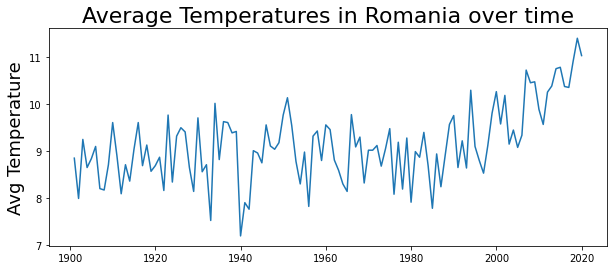

In [18]:
plt.figure(figsize=(10, 4))
plt.plot(annual_temperatures['Temperature'])
plt.title('Average Temperatures in Romania over time', fontsize=22)
plt.ylabel('Avg Temperature', fontsize=18)
plt.show()

## Visually, we can say that this time series is not stationary. The mean is not constant, neither the standard deviation. 

## But let's run a statistical test, the Augmented Dickey Fuller test to see if the time series is indeed non-stationary.

In [19]:
results = adfuller(annual_temperatures['Temperature'])
print("The p-value is: ", results[1])

The p-value is:  0.997195834149218


## Now we have no doubt that this time series is not stationary (the p-value > 0.05). **The data seems to follow a random walk with drift**.

## Make a stationary time series
## Because the time series is a random walk with drift, we will take first differences to make it stationary.

In [20]:
changed_temperatures = annual_temperatures.diff()
changed_temperatures = changed_temperatures.dropna()

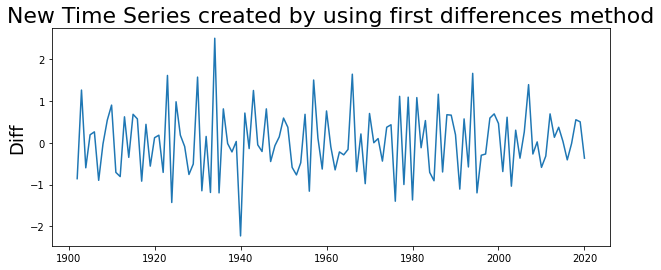

In [21]:
plt.figure(figsize=(10, 4))
plt.plot(changed_temperatures['Temperature'])
plt.title('New Time Series created by using first differences method', fontsize=22)
plt.ylabel('Diff', fontsize=18)
plt.show()

Looks stationary. The mean seems to be centered, the standard deviation is almost constant. There is no seasonality. 

## ACF

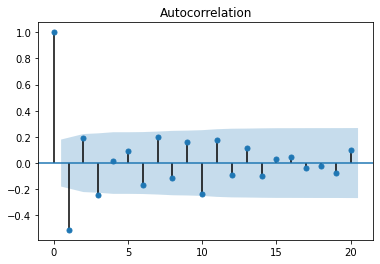

In [22]:
acf_plot = plot_acf(changed_temperatures['Temperature'], lags = 20)

## PACF

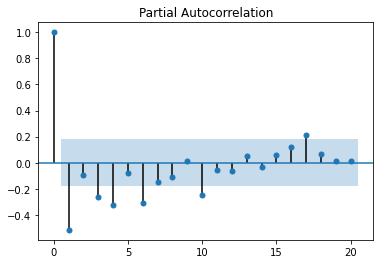

In [23]:
pacf_plot = plot_pacf(changed_temperatures['Temperature'], lags = 20)

## Looking at ACF and PACF plots, we don t find a clear pattern (except the negative lag 1 autocorrelation for both plots).

## Based on the plots above, we will fit the temperature data to the following models:
- AR(1)
- MA(1)
- ARMA(1, 1)
- ARMA(1, 3)

Then, we will use the Akaike Information Criterion (AIC) to measure godness-of-fit. 

In [24]:
model_ar1 = ARMA(changed_temperatures, order=(1, 0))
result_ar1 = model_ar1.fit()
print("The AIC for AR(1) is: ", result_ar1.aic)

The AIC for AR(1) is:  253.85134779847857


In [25]:
model_ma1 = ARMA(changed_temperatures, order=(0, 1))
result_ma1 = model_ma1.fit()
print("The AIC for MA(1) is: ", result_ma1.aic)

The AIC for MA(1) is:  235.10899909516456


In [26]:
model_arma11 = ARMA(changed_temperatures, order=(1, 1))
result_arma11 = model_arma11.fit()
print("The AIC for ARMA(1, 1) is: ", result_arma11.aic)

The AIC for ARMA(1, 1) is:  236.59217939049273


In [27]:
model_arma13 = ARMA(changed_temperatures, order=(1, 3))
result_arma13 = model_arma13.fit()
print("The AIC for ARMA(1, 3) is: ", result_arma13.aic)

The AIC for ARMA(1, 3) is:  233.14386742647125


## The ARMA(1, 3) has the lowest AIC => we will choose this model.

## Since ARMA (1, 3) is the best model for the First Difference of the time series, we use ARIMA(1, 1, 3) model to forecast the temperatures.

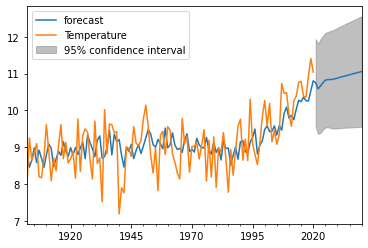

In [28]:
# plot the original series and the forecasted series
model = ARIMA(annual_temperatures, order = (3, 1, 1))
result = model.fit()
result.plot_predict(start='1902-01-01', end='2040-01-01')
plt.show()

In [29]:
result

## According to the model, the temperature is expected to be 0.5 degrees higer in 20 years, but the 95% confidence interval around that is min 4 degrees. Ne vom praji.

## Residuals Diagnosis

In [30]:
residuals = result.resid

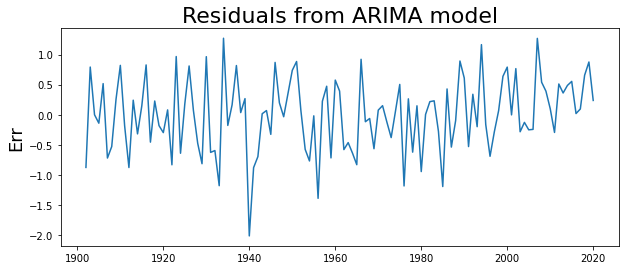

In [31]:
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title('Residuals from ARIMA model', fontsize=22)
plt.ylabel('Err', fontsize=18)
plt.show()

## Next we will check if these residuals are normally distributed and looks Gaussian or not. So we will plot the density plot to check this.

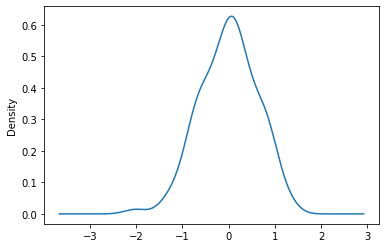

In [32]:
residuals.plot(kind='kde')
plt.show()

## This looks normal with a long left tail and centered at Zero.

In [33]:
residuals.describe()

count    119.000000
mean      -0.003271
std        0.611891
min       -2.017536
25%       -0.460849
50%        0.035134
75%        0.410897
max        1.272122
dtype: float64

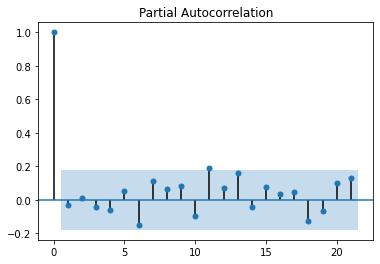

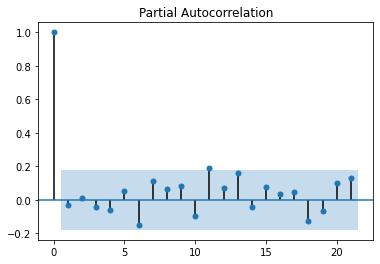

In [34]:
plot_pacf(residuals)

In [35]:
print('Error:', np.sqrt(np.mean(residuals**2)))

Error: 0.6093230364979751


## The mean of the residual is close to Zero and there is no significant correlation also that we can see in the pacf plot for residuals.

## The residual diagnostics looks like a white noise since 95% of our sample autocorrelations is between the two blue lines and it meets all our criteria for a good forecast and prediction.



---



# Ecuatia matematica a modelului:

In [36]:
# plot the original series and the forecasted series
model = ARIMA(annual_temperatures, order = (3, 1, 1))
model_fit = model.fit()

In [37]:
# summary of the model
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Temperature   No. Observations:                  119
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -109.866
Method:                       css-mle   S.D. of innovations              0.606
Date:                Mon, 23 May 2022   AIC                            231.733
Time:                        14:37:34   BIC                            248.407
Sample:                    01-01-1902   HQIC                           238.504
                         - 01-01-2020                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0176      0.010      1.805      0.074      -0.002       0.037
ar.L1.D.Temperature     0.0600      0.102      0.590      0.556      -0.139       0.259
ar.L2.D.Temperat

Lag 1 is significant, Lag 2 is not significant (p-value = 0.206 > 0.05), Lar 3 is very significant. So Lag 2 => bye

# **yt = 0.0068 - 0.41yt-1 - 0.40Et-1 - 0.38Et-3 + Et-1**



---



---



---



In [38]:
annual_temperatures

,Temperature
Date,
1901-01-01,8.85
1902-01-01,7.99
1903-01-01,9.25
1904-01-01,8.65
1905-01-01,8.84
...,...
2016-01-01,10.38
2017-01-01,10.36
2018-01-01,10.91


In [39]:
# get prediction start and end dates
train_end = dt.datetime(2010, 1, 1)
test_end = dt.datetime(2020, 1, 1)

train_data = annual_temperatures[:train_end]
test_data = annual_temperatures[train_end + pd.DateOffset(years=1): test_end]

In [40]:
train_data.tail()

,Temperature
Date,
2006-01-01,9.34
2007-01-01,10.73
2008-01-01,10.46
2009-01-01,10.48
2010-01-01,9.89


In [41]:
test_data.head()

,Temperature
Date,
2011-01-01,9.57
2012-01-01,10.26
2013-01-01,10.39
2014-01-01,10.76
2015-01-01,10.79


## Fit the ARIMA Model

In [49]:
# define model
model = ARIMA(train_data, order=(3, 1, 1))

In [50]:
# fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.17284059524536133


In [51]:
# summary of the model
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:          D.Temperature   No. Observations:                  109
Model:                 ARIMA(3, 1, 1)   Log Likelihood                -101.732
Method:                       css-mle   S.D. of innovations              0.610
Date:                Mon, 23 May 2022   AIC                            215.464
Time:                        14:38:08   BIC                            231.612
Sample:                    01-01-1902   HQIC                           222.012
                         - 01-01-2010                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0100      0.007      1.445      0.152      -0.004       0.024
ar.L1.D.Temperature     0.0879      0.105      0.834      0.406      -0.119       0.294
ar.L2.D.Temperat

In [45]:
# get prediction start and end dates
pred_start_date = test_data.index[0]
pred_end_date = test_data.index[-1]

In [46]:
train_data.index[0]

Timestamp('1901-01-01 00:00:00', freq='AS-JAN')

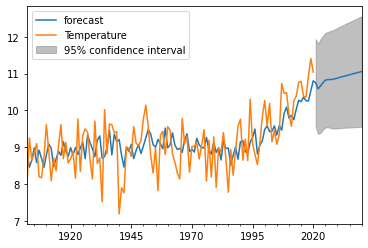

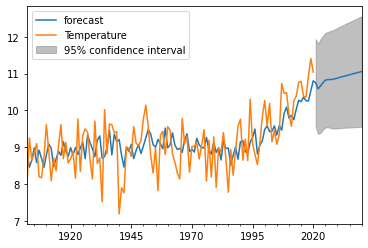

In [47]:
result.plot_predict(start='1902-01-01', end='2040-01-01')

KeyError: ignored

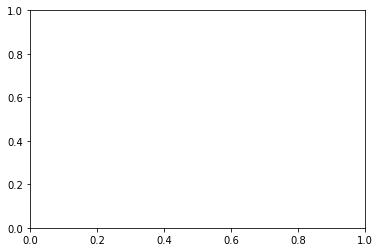

In [48]:
model_fit.plot_predict(start=train_data.index[0], end=train_data.index[-1])

In [ ]:
# get the predictions and residuals
predictions = model_fit.predict(start=pred_start_date, end=pred_end_date)

In [ ]:
predictions

In [ ]:
predictions

In [ ]:
test_data - predictions